In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

## 1. EDA and data preprocessing

### A)

In [57]:
data = pd.read_csv('data_DL/dataset.csv')

In [58]:
data.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [59]:
print('Number of records:\t', data.shape[0])
print('Number of attributes:\t', data.shape[1])

Number of records:	 19906
Number of attributes:	 2


In [60]:
duplicates = data[data.duplicated()]
print('Number of duplicate rows:', duplicates.shape[0])

Number of duplicate rows: 0


In [61]:
missing = data[data.isnull().any(axis=1)]
print('Number of rows with missing value:', duplicates.shape[0])

Number of rows with missing value: 0


In [62]:
image_path = 'data_DL\\images'

missing_images = []

for img_name in data['ID']:
    img_file = os.path.join(image_path, img_name)
    if not os.path.exists(img_file):
        missing_images.append(img_name)

print('Number of missing images (jpg):', len(missing_images))

Number of missing images (jpg): 0


Funkcia na nájdenie chýbajúcich obrázkov podľa ID obrázka.

In [63]:
print(data['Class'].value_counts())

Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


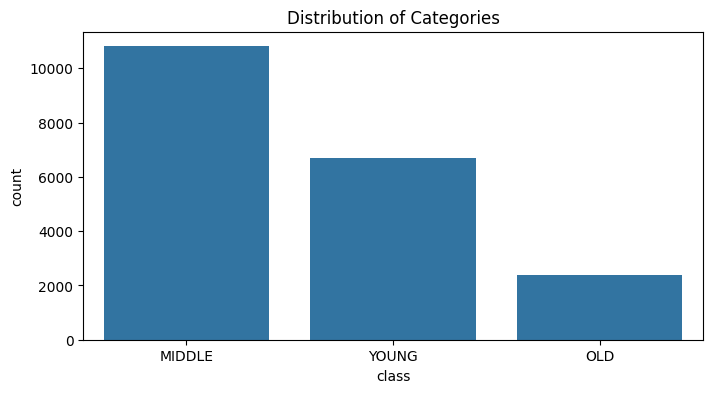

In [64]:
plt.figure(figsize=(8, 4))
sns.countplot(x='Class', data=data)
plt.xlabel('class') 
plt.title('Distribution of Categories')
plt.show()

Počet záznamov pre jednotlivé kategórie.

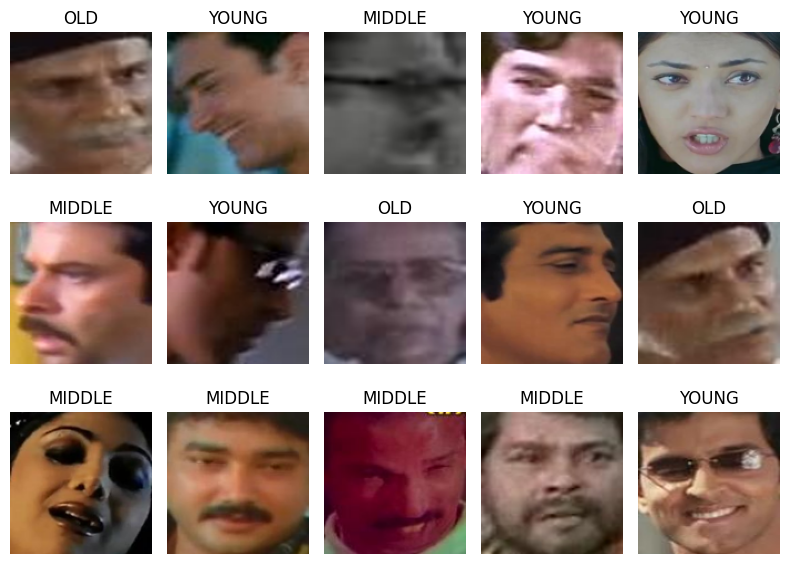

In [65]:
image_dir = 'data_DL\\images'
sample_data = data.sample(15)

fig, axes = plt.subplots(3, 5, figsize=(8, 6))
axes = axes.flatten()

for i, (index, row) in enumerate(sample_data.iterrows()):
    img_id = row['ID']
    category = row['Class']

    img_path = os.path.join(image_dir, img_id)
    img = Image.open(img_path)

    img = img.resize((128, 128))

    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Zobrazenie náhodných obrázkov z datasetu.

In [66]:
data['image_path'] = data['ID'].apply(lambda x: os.path.join(image_dir, x))

In [67]:
def image_to_numpy(img_path):
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)
    
    img_resized = tf.image.resize(img_array, (128, 128))
    
    return img_resized.numpy()

Funkcia na konverziu obrázka do numpy array a resizing na jednu rovnakú veľkosť.

In [68]:
data['image_data'] = data['image_path'].apply(lambda x: image_to_numpy(x))
data.head()

,ID,Class,image_path,image_data
0,377.jpg,MIDDLE,data_DL\images\377.jpg,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51...."
1,17814.jpg,YOUNG,data_DL\images\17814.jpg,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47...."
2,21283.jpg,MIDDLE,data_DL\images\21283.jpg,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3..."
3,16496.jpg,YOUNG,data_DL\images\16496.jpg,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21...."
4,4487.jpg,MIDDLE,data_DL\images\4487.jpg,"[[[31.398438, 30.398438, 36.398438], [29.26171..."


In [69]:
data = pd.get_dummies(data, columns=['Class'], prefix='class')
data = data.drop(['ID', 'image_path'], axis=1)

data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']] = data[['class_MIDDLE', 'class_OLD', 'class_YOUNG']].astype(int)

data.head()

,image_data,class_MIDDLE,class_OLD,class_YOUNG
0,"[[[51.0, 47.0, 48.0], [51.0, 47.0, 48.0], [51....",1,0,0
1,"[[[47.0, 30.0, 36.0], [47.0, 30.0, 36.0], [47....",0,0,1
2,"[[[43.98047, 39.98047, 38.98047], [43.98047, 3...",1,0,0
3,"[[[21.0, 21.0, 21.0], [21.0, 21.0, 21.0], [21....",0,0,1
4,"[[[31.398438, 30.398438, 36.398438], [29.26171...",1,0,0


One hot encoding kategorických atribútov.

In [70]:
X = np.stack(data['image_data'].to_numpy())
y = data[['class_YOUNG', 'class_MIDDLE', 'class_OLD']].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [tf.convert_to_tensor(d, dtype=tf.float32) for d in [X_train, X_test, y_train, y_test]]
X_train, X_test, y_train, y_test = datasets

Premena dát z pandas dataframe do numpy array a rozdelenie na trénovaciu a testovaciu množinu. Konverzia dát na tensor pre hlboké učenie.

In [71]:
rescale_layer = Rescaling(scale=1.0/255)

X_train_transformed = rescale_layer(X_train)
X_test_transformed = rescale_layer(X_test)

Tránsformácia hodnôt datasetu do intervalu [0;1].

In [72]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_transformed, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_transformed, y_test))

In [73]:
batch_size = 32

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

for images, labels in train_dataset.take(1):
    print('Train image batch shape:\t', images.shape)
    print('Train label batch shape:\t', labels.shape, '\n')

for images, labels in test_dataset.take(1):
    print('Test image batch shape: \t', images.shape)
    print('Test label batch shape: \t', labels.shape)

Train image batch shape:	 (32, 128, 128, 3)
Train label batch shape:	 (32, 3) 

Test image batch shape: 	 (32, 128, 128, 3)
Test label batch shape: 	 (32, 3)


Rozdelenie trénovacieho a testovacieho datasetu na dávky (batch).

### B) Zhodnotenie

##### Analýza a čistenie dát
Dataset sme spracovali podľa štandardných metód. Keďže dataset obsahoval iba 2 atribúty, rozšírená analýza atribútov nebola potrebná. Atribút **Class** obsahoval 3 hodnoty, pričom distribúcia bola veľmi nerovnomerná. Rozhodli sme sa, že nebudeme znižovať počet záznamov pre každú triedu, pretože by sme museli odstrániť veľmi veľa záznamov, čo by mohlo viesť k nepresným predikciám aj keď by tento prístup v iných prípadoch mohol pomôcť k zvýšeniu presnosti modelu. Dataset neobsahoval duplicitné riadky, chýbajúce hodnoty a nechýbali ani konkrétne obrázky ku ktorým sa dalo dostať podľa ID.

##### Predspracovanie dát
Kategorický atribút Class sme zakódovali pomocou **One Hot Encodingu**, pretože obsahoval iba 3 unikátne hodnoty. Obrázkom sme zmenili veľkosť na **128x128 pixelov** a premenili sme ich na formát numpy array a neskôr tensor a hodnoty sme pretransformovali do hodnôt 0 až 1. Odstránili sme nepotrebné atribúty a rozdelili sme dáta na trénovaciu a testovaciu sadu. Nakoniec sme tieto datasety predpripravili na dávkové spracovanie.

## 2. Modeling and evaluation

### A) Najlepší model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128, 128, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2), 

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(), 

    tf.keras.layers.Dense(256, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu', 
                          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,89

 Total params: 1,737,155 (6.63 MB)

 Trainable params: 1,735,171 (6.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [75]:
history = model.fit(
    train_dataset,
    epochs=11,
    validation_data=test_dataset
)

Epoch 1/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 471s 904ms/step - accuracy: 0.4912 - loss: 11.2496 - val_accuracy: 0.5477 - val_loss: 7.9508
Epoch 2/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 445s 894ms/step - accuracy: 0.5769 - loss: 6.8154 - val_accuracy: 0.5542 - val_loss: 5.0659
Epoch 3/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 494s 992ms/step - accuracy: 0.6177 - loss: 4.2103 - val_accuracy: 0.5512 - val_loss: 3.4120
Epoch 4/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.6512 - loss: 2.7502 - val_accuracy: 0.6153 - val_loss: 2.1995
Epoch 5/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 543s 1s/step - accuracy: 0.6835 - loss: 1.9339 - val_accuracy: 0.6261 - val_loss: 1.6897
Epoch 6/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.7083 - loss: 1.4939 - val_accuracy: 0.7109 - val_loss: 1.2912
Epoch 7/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 447s 898ms/step - accuracy: 0.7146 - loss: 1.2449 - val_accuracy: 0.6921 - val_loss: 1.1860
Epoch 8/11
498/498 ━━━━━━━━━━━━━━━━━━━━ 486s 977ms/step - accuracy: 0.7328 - loss: 1

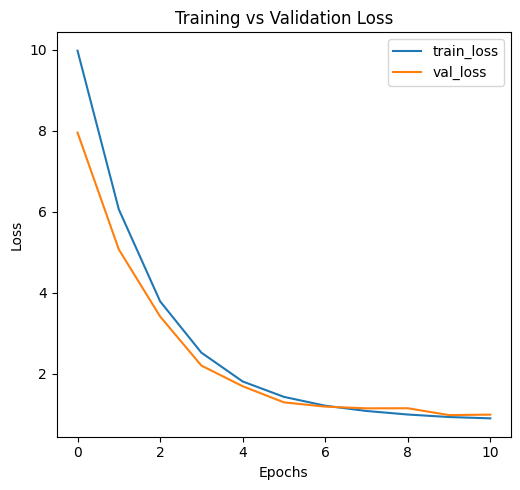

In [77]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Na základe grafu a výsledkov:

Obidve krivky (tréningová a validačná strata) postupne klesajú a približujú sa, čo naznačuje, že model je dobre trénovaný.
Nedochádza k výraznému zvýšeniu validačnej straty, čo by indikovalo pretrénovanie.

Presnosť modelu:

Tréningová presnosť: 75%.
Validačná presnosť: 70%.
Tento 5% rozdiel je malý a naznačuje, že model generalizuje dobre na validačných dátach.

### B) Zhodnotenie

Počas vývoja a testovania sme skúšali viacero rôznych modelov s rôznymi architektúrami a hyperparametrami. Tento model sa ukázal ako najlepší spomedzi všetkých testovaných variantov. Dôvody, prečo bol zvolený, sú nasledujúce:

#### Takmer žiadny overfitting ani underfitting
- Model dosahuje veľmi vyrovnané výsledky medzi tréningovými a validačnými dátami, čo dokazuje jeho schopnosť efektívne generalizovať.  
- Rozdiel medzi tréningovou presnosťou (**75%**) a validačnou presnosťou (**70%**) je minimálny, čo znamená, že:
  - Model sa **nepretrénoval** na tréningových dátach (nemá výrazný overfit).
  - Model sa zároveň dostatočne **naučil** (nemá underfit).

#### Dobrý výkon a presnosť
- Model vykazuje vysokú presnosť na validačných dátach, čo potvrdzuje jeho efektivitu pri klasifikácii nových, neznámych vzoriek.  

#### Porovnanie s inými modelmi
- V porovnaní s jednoduchšími architektúrami mal tento model lepší výkon na validačných dátach.  
- Na druhej strane, komplexnejšie modely často trpeli pretrénovaním (**overfit**) alebo neprinášali podstatné zlepšenie výkonnosti (**underfit**).

<small>Percentuálny podiel práce členov na projekte: Vlastislav Pokorný: 50%, Leon Radó: 50%</small>